## Test case

In this notebook, I'll discuss the three different approaches taken to tackle this problem. I'll start by taking a quick preliminary look at the dataset, describe each approach, follow with a description of the object detection application and finally, I'll compare the results, extract some conclusions and propose future work.

The evaluation will be done on the test set which will be treated like a production set and will not take decisions based on the latter, rather I'll use a validation set (which will be extracted from the FashionMNIST dataset to take decisions). That being said, in the end, the models will be evaluated and compared in the test set, to see how well they fare.

The instructions for running the training phase and evaluation phase can be found in the README.txt.

### Table of contents:
1. [Preliminary analysis](#preliminary)
2. [Approach 1](#approach_1)
3. [Approach 2](#approach_2)
4. [Approach 3](#approach_3)
5. [Application](#application)
6. [Conclusions and Future work](#conclusions)

I'll start by adding all of the imports I'll be needing for this notebook.

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import torch.nn as nn
import sys
sys.path.append('..')
import utils.notebook_utils as nb_utils
from utils.config import MEAN_PIXEL, STD_PIXEL, LIST_CLASS
from utils.data_loaders import CustomFashionMNIST


## Preliminary Exploration <a class="anchor" id="preliminary"></a>
Let's do a quick overview on the data before we go on to analyze the images per se. 

In [3]:
# transforms
transform = Compose([ToTensor()])

# datasets
trainset = CustomFashionMNIST('../data', download=True, train=True, transform=transform)
testset = CustomFashionMNIST('../data', download=True, train=False,transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)


The trainset contains 60000 images of 10 classes with 6000 values each. this is a perfectly well balanced dataset which is one problem less we have to worry about. The testset is equally balanced but contains only 10000. Each image is 28x28x1 which is pretty small for an image dataset. Because of this we will have to be carefull not to remove too many pixels in the convolution network.

Let's visualize a value of each class of the dataset. As we'll see further on, there are some pecularities for the different classes such as the fact that all of the classes are symetrical with respect to the vertical axis except for the shoes, sandals and ankle boots, and that T-shirt/top, Pullover, Coat and Shirt are pretty similar.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


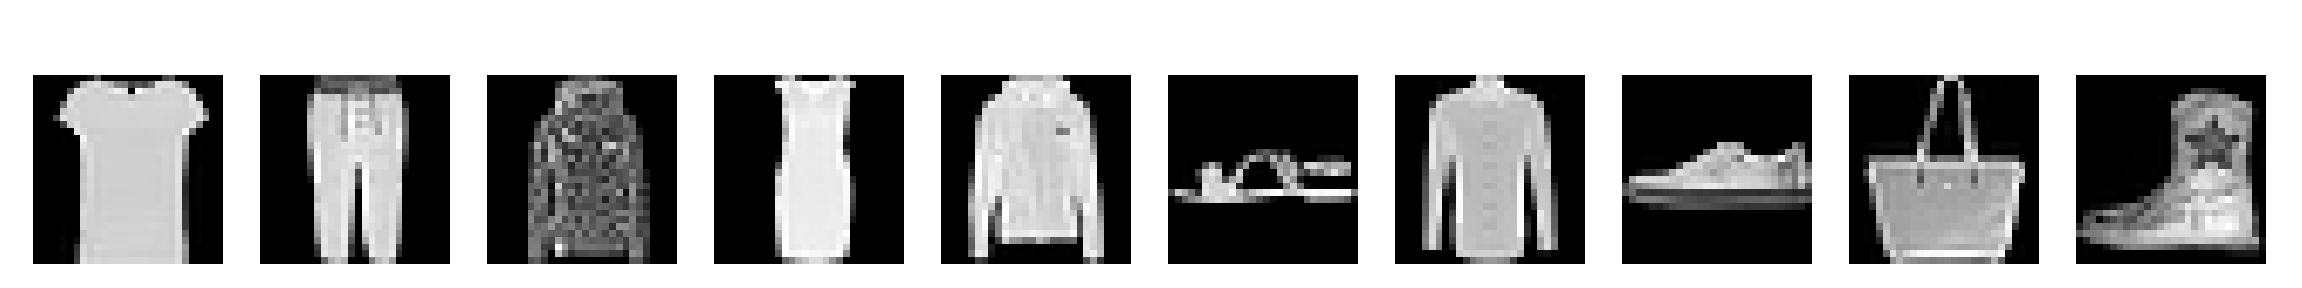

In [4]:
# Run to visualize a random image of each class from the train set.
nb_utils.visualize_dataset_sample(trainset)

## Approach 1 <a class="anchor" id="approach_1"></a>

For the first approach I've decided to go for a relatively simple convolutional neural network to have a first running approach over which to iterate. The architecture can be seen below.

### Architecture 
Finding an optimal number of hidden units and hidden layers in a networks is an extremely difficult process. For this, reason, and given the limited time, I've decided to base my architecture following principles from other sucessful neural networks wich have worked in the past for image classification. In particular, this network follows these few rules of thumb:

#### Convolutional layers
- The size of the resulting image width and heigh shrink roughly to half their previous values, while the number of channels grows by powers of two.
- After a convolutional layer is added, a maxpool layer is used in order to both reduce the number of layers and smoothen the output. The maximum is usually used although the average could also be computed. 

#### Fully connected layers
- For the fully connected layers, a simliar process applies where the number of hidden units shrink by a half for each added.
- Needless to say, the output corresponts to a vector of the number of classes which are to be classfied.

In order to choose and calculate the kernels, strides, padding and channels, and the length of input of the first fully connected layer, I've developed the ```get_output_shape(width, height, channels, kernel, stride=1, padding=0)``` function to help with the process.

If we run the following script, we obtain details about the intermediate image dimensions:

In [5]:
# Calculate input of fully connected layer.
w, h, c = 28, 28, 1
print("Input Image:\t", w, h, c)
w, h, c = nb_utils.get_output_shape(28, 28, 8, 3, stride=1) # nn.Conv2d(1, 8, 3, stride=1) grayscale image
print("conv1 output:\t", w, h, c)
w, h, c = nb_utils.get_output_shape(w, h, 8, 2, stride=2) # MaxPool2d(2, 2)
print("MaxPool output:\t", w, h, c)
w, h, c = nb_utils.get_output_shape(w, h, 16, 3, stride=1) # conv2d(8, 16, 3, stride=1)
print("conv2 output:\t", w, h, c)
w, h, c = nb_utils.get_output_shape(w, h, 16, 2, stride=2) # MaxPool2d(2, 2)
print("MaxPool output:\t", w, h, c)

print("First fully connected layer input:", w*h*c)

Input Image:	 28 28 1
conv1 output:	 26 26 8
MaxPool output:	 13 13 8
conv2 output:	 11 11 16
MaxPool output:	 5 5 16
First fully connected layer input: 400


#### First CNN approach

For this approach I've used two convolutional layers with a 3x3 kernel, a stride of 1 and no padding, as well as a maxpool of kernel 2x2 and stride 2 to reduce the image after each convolution is applied. Finally, I've chosen two fully connected layers for the end. The network model using pytorch can be seen below and by running the next cell, a summary of the different parameters will be displayed. Notice there are only 34,138 trainable parameters in this network which is quite small for an image classification network.

In [6]:
class CNN(nn.Module):
    '''
    Convolutional neural network for a 28x28 grayscale image.
    '''
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1)
        self.fc1 = nn.Linear(5 * 5 * 16, 80)
        self.fc2 = nn.Linear(80, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Softmax layer is not required since it is used in the Loss function
        return x
summary(CNN(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
         MaxPool2d-2            [-1, 8, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]           1,168
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                   [-1, 80]          32,080
            Linear-6                   [-1, 10]             810
Total params: 34,138
Trainable params: 34,138
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.13
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


### Loss Functions
We've chosen the cross entropy loss function because it's the most appropriate for multiclass classificaition since its minimization is equivalent to maximum likelihood of our model's distribution to match the real data's distribution. Furthermore, it has the possibility of adding weight to different classe. Straightaway, this functionality does not seem necessary since the dataset is balanced, but I'll discuss at the future work possibilities of where this could be used. We'll actually use the same loss for all three approaches.

Since pytorch's CrossEntropyLoss function already applies the log-Softmax function, we don't have to add it in the forward. If we are intersted in obtaining a probability per class we would have to use LLLoss and add the softmax function in the forward. 
Furthermore, to obtain the predicted class, we therefore only have to obtain the class with the maximum value.

$$ \mathcal{L(class,y)} = -log\left( \frac{e^{y_c}}{\sum_{c}^{classes}e^{y_c}}\right)$$


### Training and Optimizer

For the training I used mini-batches of size 128 which made sure that each batch had enough representation of all 10 classes. For the optimizer, I used the Adam optimizer since it has proven to be effective  thanks to its ability to adapt and stabilize the direction of descent in multiple scenarios.

### Metrics

For this classification task, we'll choose the accuracy as the metric to go with, since it is the one that the test case specifies to optimize. In this simple problem, where we have no class imbalance this metric is appropriate enough. If we had a class imbalance, we would have to look at other metrics such as recall, precision and F1 measures, according to the business needs of the problem.

### Hyperparameters
Because of the lack of time, only the learning rate was tuned using a small cross validated grid search. The script which allows for a grid search is ```hyperparameter_optimization```. 
In order to run apply the following changes:
```
## Variables to change
# Where you wish the model to be stored in the artifacts folder.
model_name = "cnn_1_500"
# Data augmentation on the training dataset or not.
data_augmentation = False
# CNN or CNN2 networks.
Network = CNN
# Apply hyperparameter search or just train.
hyperparameter_search = False
# Dictionary with list of values per hyperparameter for grid search.
params_options = {   
    'lr': [0.001],
}


and run:

```python -m scripts.hyperparameter_optimization```

### Results

The following two plots show the loss (left) and accuracy (right) of the train and validation per epoch. The fashion MNIST dataset is split into train (80%) and validation (20%). For the test set, we use the fashion MNIST dataset. On the accuracy plot, there is also the final evaluation on the test set and the state of the art which is 95% accuracy.

The train and validation loss and accuracy metrics are very similar. This brought me to believe that there was a bug in the skorch library I used, and so I spent much time debugging. However, since as the number of epochs increase the differece gets starker and I have no reason to believe that this is due to a bug.

<table><tr><td><img src="../results/cnn_1_500/loss_epoch.png" width="500"/></td><td><img src="../results/cnn_1_500/accuracy_epoch.png" width="500"/></td></tr></table>

Finally, we evaluate on the test data and we get worse results than the train set which is expected. We can also conclude that we have slightly overfit the data because the validation accuracy decreases as the network overfits its data.  

Notice also the importance of the number of epochs per train. The table below compares the network trained with 100 or 500 epochs.


|             | Train Acc | Val Acc | Test Acc |
|-------------|-----------|---------|----------|
| CNN 1 - 100 | 0.8421    | 0.8426  | 0.7786   |
| CNN 1 - 500 | 0.9056    | 0.8911  | 0.8859   |

To understand what type of errors we're commiting, let's take a look at the confusion matrix. The shirt class seems to be confused, as was expected, with the T-shirt/top, pullover and coat classes.

<img src="../results/cnn_1_500/confusion_matrix.png" width="500"/>


Notice that the state of the art results are around 95% of accuracy. We can therefore suppose the Bayes optimal accuracy must be that at least. This means that it is possible for us to optimize our model since there is avoidable bias. In order to reduce the latter, we have a few options:
- Tune the hyperparameters to obtain a better model
- Get a more complex model. 
Surely, the second approach will give us a more promising result.

## Approach 2: Larger network with regularization. <a class="anchor" id="approach_2"></a>


### Architecture: CNN2
From the results in the first approach, we have seen that our network either can't learn  (or at least, not fast enough) to reach the optimal bayes accuracy. As I have discussed previously, this might be because the network is too small. In this approach I'm going to increase the size of the networks, that is, the number of neurons and number of hidden layers.

In order to increase the size of the network, I have decided to add padding to create 'same' convolutions (convolutions that maintain the image size). Notice that, by applying this simple change as well as by doubling the number of output channels, we get a larger fully connected layer. This allows us to add an extra fully connected layer following the rules of thumbs stated in the previous section. In totall now we have 1,546,546 parameters.


In [7]:

class CNN2(nn.Module):
    '''
    Convolutional neural network for 28x28 grayscale image.
    '''
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(7 * 7 * 32, 7 * 7 * 32 // 2)
        self.fc2 = nn.Linear(7 * 7 * 32 // 2, 7 * 7 * 32 // 4)
        self.fc3 = nn.Linear(7 * 7 * 32 // 4, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # We don't need the softmax layer since it is used in the Loss function
        return x

summary(CNN2(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 784]       1,230,096
            Linear-6                  [-1, 392]         307,720
            Linear-7                   [-1, 10]           3,930
Total params: 1,546,546
Trainable params: 1,546,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 5.90
Estimated Total Size (MB): 6.09
----------------------------------------------------------------


### Regularization
Since increasing the size of the network can easily bring make the model to overfit, and since the previous method did so, I added a L2 regularization also known as weight decay. Different values for weight decay were evaluated using cross validation. I decided not to choose dropout regularization since there are too many variables that would have to be optimizes (percentage of dropout per layer for example).

### Results
As we can see again the table, increasing the network size improved our results on the test set and the regularization seems to have worked to avoid excessive over fitting as we can see from the accuracy and loss plots.


Since this netwok is way bigger, we also expect the number of epochs necessary to train to increasae. Notice how with 500 iterations, the previous simple method outperforms the method but by training with 1000 iterations, this method is better.

|            | Train Acc | Val Acc | Test Acc |
|------------|-----------|---------|----------|
| CNN2 - 500 | 0.9025    | 0.8977  | 0.8839   |
| CNN2 - 1000| 0.9152    | 0.9036  | 0.8976   |

<table><tr><td><img src="../results/cnn_2/loss_epoch.png" width="500"/></td><td><img src="../results/cnn_2/accuracy_epoch.png" width="500"/></td></tr></table>

Having a larger network, this approach takes approximately 12 hours to train 1000 epochs. As future work, I'll mention better ways of dealing with the numbe of epochs. 
<table><tr><td><img src="../results/cnn_2_1000/loss_epoch.png" width="500"/></td><td><img src="../results/cnn_2_1000/accuracy_epoch.png" width="500"/></td></tr></table>

Furthermore, since we did not address the problem of class confusions it is not surprise that it persists in the confusion matrix.
<img src="../results/cnn_2_1000/confusion_matrix.png" width="500"/>



## Architecture 3 - Data augmentation <a class="anchor" id="approach_3"></a>

### Data augmentation
As a third improvement, to reduce the overfitting problem and help our neural network generalize better to unseen images, I decided to do some data augmentation. Pytorch has a pretty convenient DataLoader object which allows for on the fly random image transformations. The most logical transformation that we can do to most of the images is the horizontal flip since, as I mentioned in the first part, all classes except for shoes, sandals and ankle boots are symetrical with respect to the vertical axis. as for the shoes however, these appear to always point to the same direction. I'll discuss this further in future work.

It is **vital** that this data augmentation is only applied during the training set, as we want the dev set to have the same distribution as the test set, not to mention that we do not want any type of data leakage to occur. For this reason, I created the CustomFashionMNIST which is able to apply different transformations for the train and dev/test sets as well as different transformations per class (in the training step). 

### Results

|     | Train Acc | Val Acc | Test Acc |
|-----|-----------|---------|----------|
| CNN | 0.8974    | 0.8970  | 0.8812   |

The results of the data augmentation where somewhat disappointing. Given more time, I would have run it with 1000 iterations. However, we can see that there is not much data augmentation.

<table><tr><td><img src="../results/cnn_3/loss_epoch.png" width="500"/></td><td><img src="../results/cnn_3/accuracy_epoch.png" width="500"/></td></tr></table>

Furthermore, the data augmentation did not seem to solved the classes which I thought would benefit the most from data augmentation such as the T-Shirt, coat and pullover. Perhaps, the horizontal flips applied, added nothing of value because of the excess of symmetry in the image.

<div>
<img src="../results/cnn_3/confusion_matrix.png" width="500"/>
</div>


## Application <a class="anchor" id="application"></a>

The application consists of applying the previous methods to the task of object detection on a camera feed. This can be divided into two problems. The first is the object detection per frame and the second the application of a camera on a live feed.
###  Object Detection
In the final application there are two steps. The first is to adapt the trained models to accept any image dimension and to look for the object in the image. There are different methods to do this. Instead of using the traditional sliding window approach, I created networks that inherited from the previous models and that apply a convolutional sliding window. In order to do this, I simply substituted the region. In the future work section, I'll mention other methods which I considered but discarted given the lack of time.


In [9]:
class ProductionCNN2(CNN2):
    '''
        Fully Convoluted version of CNN2 to be able to apply to any image size.
        It can be instantiated by passing a CNN2's state_dict with pretrained models.
    '''

    def __init__(self, state_dict=None):
        super(ProductionCNN2, self).__init__()
        if state_dict is not None:
            self.load_state_dict(state_dict)

        # Convert fully connected layer to their convolutional equivalents.
        inch = 32
        out = 7 * 7 * 32 // 2
        kernel = 7

        self.last_conv1 = nn.Conv2d(in_channels=inch, out_channels=out, kernel_size=kernel)
        self.last_conv1.weight.data.copy_(self.fc1.weight.data.view(out, inch, kernel, kernel))
        self.last_conv1.bias.data.copy_(self.fc1.bias.data)

        self.last_conv2 = nn.Conv2d(in_channels=self.fc2.in_features, out_channels=self.fc2.out_features,
                                    kernel_size=1)
        self.last_conv2.weight.data.copy_(self.fc2.weight.data.view(*self.fc2.weight.data.shape, 1, 1))
        self.last_conv2.bias.data.copy_(self.fc2.bias.data)
    
        self.last_conv3 = nn.Conv2d(in_channels=self.fc3.in_features, out_channels=10, kernel_size=1)
        self.last_conv3.weight.data.copy_(self.fc3.weight.data.view(*self.fc3.weight.data.shape, 1, 1))
        self.last_conv3.bias.data.copy_(self.fc3.bias.data)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Here we apply the convolutions corresponding to CNN2's fully connected layers
        x = F.relu(self.last_conv1(x))
        x = F.relu(self.last_conv2(x))
        x = self.last_conv3(x)
        # We don't need the softmax layer since it is used in the Loss function
        return x
# Vary the image size. Remember, however, to keep the height and width larger or equal to 28.
image_size=(28, 28*3)
summary(ProductionCNN2(), input_size=(1,*image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 84]             160
         MaxPool2d-2           [-1, 16, 14, 42]               0
            Conv2d-3           [-1, 32, 14, 42]           4,640
         MaxPool2d-4            [-1, 32, 7, 21]               0
            Conv2d-5           [-1, 784, 1, 15]       1,230,096
            Conv2d-6           [-1, 392, 1, 15]         307,720
            Conv2d-7            [-1, 10, 1, 15]           3,930
Total params: 1,546,546
Trainable params: 1,546,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.67
Params size (MB): 5.90
Estimated Total Size (MB): 6.58
----------------------------------------------------------------


Notice how the output of this network varies with different input image dimensions

### Live webcam
The second part of the application consists in applying the previous object detection to a live feed. To do this, I used openCV's library to capture the images. Unfortunately, this part was not completely finished because of the lack of time.
To run the code:
````
python -m scripts.cam_application
````
Press Esc to stop the application.


### Results

Unfortunately, the results of this application are not promissing. There are a few reasons why this is. First, the fashion MNIST dataset is a non realistic dataset, so appying it in a webcam with arbitrary content is not expected to give good results directly. In the conclusion and future work, I'll discuss some of the options and alternatives to improve the problem.

## Conclusions and Future Work <a class="anchor" id="conclusions"></a>

In this project, I have developed three different approaches: the first a simple convolutional neural network, the second a larger network with regularization and the third the latter with data augmentation in the training step. I have then, expanded these networks to work as object detectors using "convolutional sliding windows" and applied it to an application.

### Results comparison
    
As we can see from the table, the most substantial gain was obtained from approach 1 to approach 2, where the size of the network was increased and regularization applied. The data augmentation, however, didn't give enough promising results in order to make us believe that it worth pursuing futher. We could neverthess try to run it with 1000 epochs or explore other augmentation techniques apart from the horizontal flip.


|            | Accuracy | Execution time (ms/instance) | Param size | Num parameters |
|------------|----------|------------------------------|------------|----------------|
| Approach 1 | 0.8839   | 0.3254                       | 138 KB     | 34,138         |
| Approach 2 | 0.8976   | 0.5082                       | 6,2 MB     | 1,546,546      |
| Approach 3 | 0.8812   | 0.5160                       | 6,2 MB     | 1,546,546      |


Notice that the first approach achieves a pretty good accuracy given the small quantity of trainable parameters that has. This makes me believe that by finetuning different hyperparameters such as those related to the adam optimizer, this method could obtain pretty decent results for an IoT-like application where a small size and low execution time of the classifier could be required.

### Other Hyperparameters and methods to explore

There are many different parameters and methods which could be explore. Ideally, given enough computational resources, a cross validated random search could be applied to find a better combination of hyper parameters. Among these, there are a few specially important to figure out: the learning rate, other strategies for normalization such as dropout or different architectures, such as an inception architecture or using skip-connections. Since I lacked the time or the computationa resources, this left me no choice but to run smaller grid searches and choose parameters based on experience. For example, the hyperparameters for the Adam optimizer were chosen as default.

### Comment on choice of library: Skorch

One of the main problems I had during this project, which highly hindered my coding process is the bad choice of library. Skorch, a library that attempts to wrap Pytorch into a Sklearn Estimator to be able to use all the different tools offered by sklearn, has a huge compatibility problem, which in my opinion makes it faulty from the start. The nature of pytorch's DataLoader class, is not compatible with sklearn's simpler data class. The goal of choosing a library was to simplify the process to spend more time on the actual analysis than on coding. Unfortunately, the scope of this project far exceded skorch's limited possibilities, meaning that I had to spend more time mending and adapting the classes, and debugging the code than on the actual analysis.

Where I to begin this project again, I would definitely code everything myself using just pytorch as most libraries have limitations in terms of compatibility with pytorch's dataset.

### Application improvements

There are two main problems with the application. The first is that we're applying the classifier to a completely different data distributions and the second is the fact that there is no class None which does not contain any values. This causes the classifier to always opine about which of the classes it predicts is there. 

These two problems can be solved by adding noise to the image background and retraining the clasifiers adding the none-of-the-above class. The second possiblity would be to create a region of interes based object algorith, so that we can apply our classifiers to regions of interest instead of every background patch we find. Finally, another option would be to use the state of the art YOLO method for image classification.

### Further Analysis

Finally, it would be interesting to carry out further analysis to figure out why the classes are confused among them. Perhaps, weights could be added to the Loss functions  so that classes which tend to clog up with predictions from other classes, can be reduced. This can be done by simply assigning a weight to the Cross Entropy Loss function used.
It would also be intersing to add early stopping so that we could find the ideal number of iterations to train on. This would optimize the networks greatly.
